# Visão Computacional - Detecção de Placas de Carro via Redes Neurais Convolucionais

In [1]:
# imports necessários

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [2]:
# dados via google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. HaarCascades treinados para placas diversas (Ref. https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)

In [3]:
# carrega os dados necessários para detectar as placas do classificador em cascata

plate_cascade = cv2.CascadeClassifier('drive/My Drive/license_plate/license_plate.xml')

# 'license_plate.xml' - arquivo com os parâmetros de nosso classificador - via haar cascades - a ser treinado

## 2. Função de detecção e desfoque da placa

In [4]:
def detect_plate(img, text=''): # a função detecta e realiza o desfoque (blur) na placa
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detecta placas e retorna as coordenadas e dimensões dos contornos das placas detectadas
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extraindo a Região de Interesse da placa para desfoque (blurring)
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # representando os contornos detectados desenhando retângulos ao redor das bordas
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate # retorna a imagem processada

## 3. Função display para nossa imagem alvo

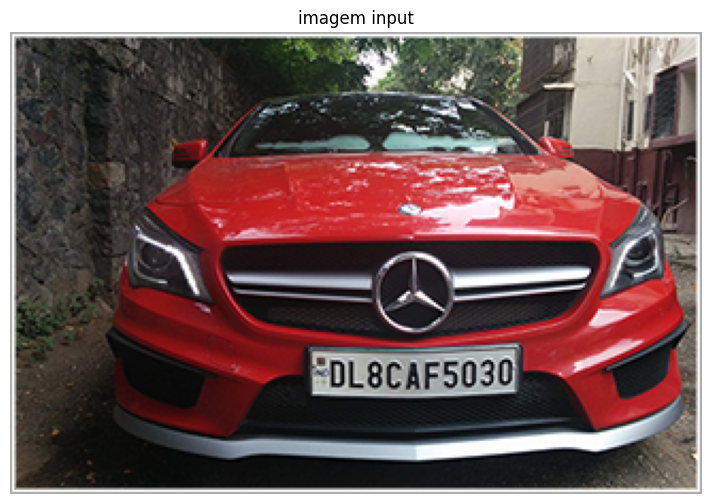

In [5]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('drive/My Drive/license_plate/car.jpg')
display(img, 'imagem input')

In [6]:
# obtendo a placa a partir da imagem processada

output_img, plate = detect_plate(img)

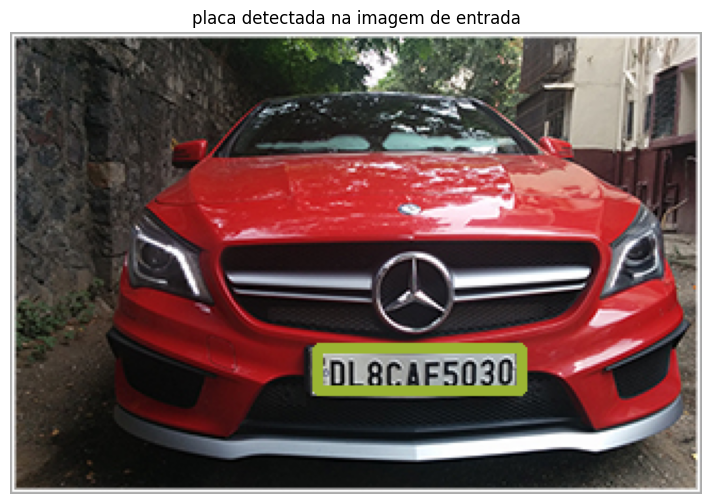

In [7]:
display(output_img, 'placa detectada na imagem de entrada')

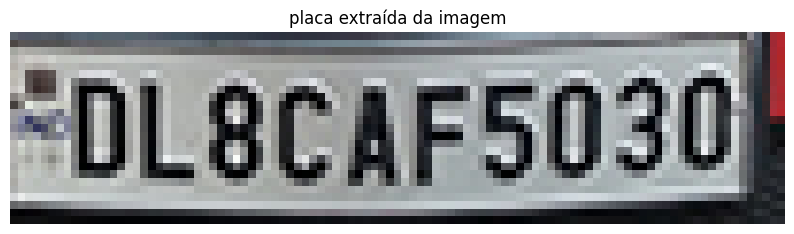

In [8]:
display(plate, 'placa extraída da imagem')

## 4. Segmentação de imagens (contorno - Vide Demo 4)

In [9]:
# combinando os contornos com a placa

def find_contours(dimensions, img) :

    # encontra os contornos na imagem
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # recuperando dimensões potenciais
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # verificando os maiores 5 ou 15 contornos da placa exemplo
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contorno.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detecta o contorno na imagem binária e retorna as coordenadas do retângulo que o envolve
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # verificando as dimensões do contorno para filtrar os caracteres pelo tamanho do contorno
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #armazena a coordenada x do contorno do caractere, para ser usada posteriormente na indexação dos contornos

            char_copy = np.zeros((44,24))
            # extraindo cada caractere usando as coordenadas do retângulo delimitador.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # torna o resultado formatado para classificação: inverte as cores
            char = cv2.subtract(255, char)

            # redimensionando a imagem para 24x44 com borda preta
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # lista que armazena a imagem binária da placa (ainda não classificada)

    # retorna os caracteres em ordem crescente em relação à coordenada x (caractere mais à esquerda primeiro)

    plt.show()

    # função arbitrária que armazena lista ordenada de índices de caracteres

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx]) # armazena imagens das placas de acordo com seu índice
    img_res = np.array(img_res_copy)

    return img_res

In [10]:
# encontrando caracteres nas imagens resultantes

def segment_characters(image) :

    # pré-processamento de imagem de placa recortada

    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # deixa as bordas brancas

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # estimativas de tamanhos de contornos de caracteres das placas "cortadas"

    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contorno.jpg',img_binary_lp)

    # obtendo contornos dentro da placa "cortada"

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

## 5. Caracteres Segmentados

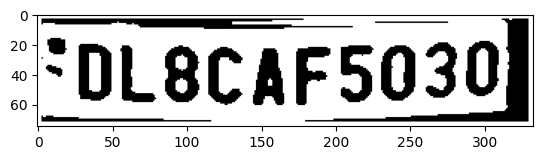

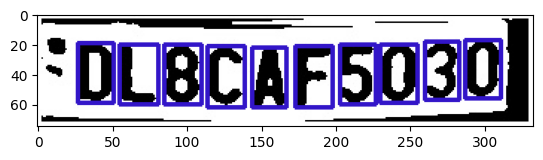

In [11]:
char = segment_characters(plate)

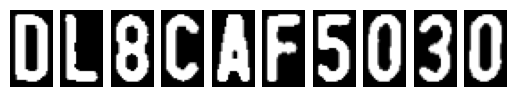

In [12]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'drive/My Drive/license_plate/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # diretório de destino - imagens treinamento
        target_size=(28,28),  # todas as imagens serão redimensionadas para 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # diretório de destino - imagens validação
        target_size=(28,28),  # # todas as imagens serão redimensionadas para 28x28 com batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [14]:
# métricas para verificar o desempenho do modelo durante o treinamento

def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

## 6. Construção da Rede Neural Convolucional

In [15]:
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [17]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 5, verbose=1, callbacks=callbacks)

<ipython-input-18-7b10099d3214>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
210/864 [======>.......................] - ETA: 5:21 - loss: 3.5827 - custom_f1score: 0.0238

In [ ]:
# prevendo a saída

def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterando sobre os carcateres
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparando imagem para o modelo
        y_ = np.argmax(model.predict(img), axis=1)[0] # predição da classe
        character = dic[y_] #
        output.append(character) #armazenando o resultado em uma lista

    plate_number = ''.join(output)

    return plate_number

print(show_results())

In [ ]:
# caracteres segmentados e seu valor previsto.

plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()